#**Задание**
**«Модели авторегрессии условной гетероскедаcтичности»**

Выберите ряд из первого задания.

Постройте его модель GARCH.

Оформите отчёт в Jupyter-ноутбук.

**Исследуемый временной ряд - продажи компании Х  ("monthly-sales-of-company-x-jan-6.csv").**

Установка необходимых библиотек и модулей

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from math import sqrt
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
!pip install arch

In [11]:
from arch import arch_model

Загрузка исследуемого временного ряда и его визуализация:

In [29]:
series = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")['Count']

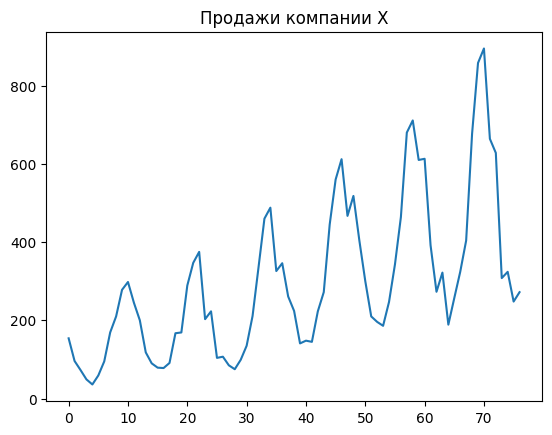

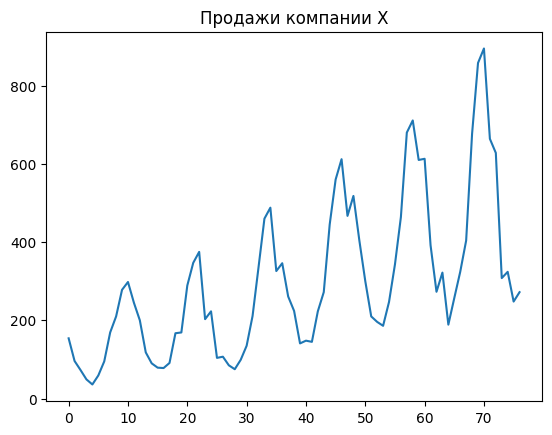

In [13]:
plt.plot(series)
plt.title('Продажи компании Х')
plt.show()

Функции для проверки на стационарность и вывода графиков:

In [14]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [15]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Перед GARCH-моделированием, необходимо исключить из ряда трендовую и сезонную составляющие. Для этого воспользуемся моделью ARIMA, и определим для нее оптимальные параметры.

Функции для подбора оптимальных параметров (p, d, q) ARIMA-модели методом поиска по сетке (Grid Search):

In [16]:
def evaluate_arima_model(X, arima_order):
  # Разделение ряда на обучающую (60%) и тестовую (40%) части:
  train_size = int(len(X) * 0.6)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # Список с предсказанными значениями:
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
    # Подсчет ошибки RMSE:
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# Оценка оптимальной комбинации параметров p, d, q:
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [47]:
series_arima = pd.read_csv('monthly-sales-of-company-x-jan-6.csv', header=0, index_col=0, parse_dates=True)
# Диапазоны значений параметров для перебора:
p_values = [4, 12]
d_values = [2, 3]
q_values = range(2, 3)
warnings.filterwarnings("ignore")
evaluate_models(series_arima.values, p_values, d_values, q_values)

ARIMA(4, 2, 2) RMSE=119.456
ARIMA(12, 2, 2) RMSE=72.569
Best ARIMA(12, 2, 2) RMSE=72.569


Модель ARIMA с полученным выше лучшим сочетанием параметров:

In [46]:
model = ARIMA(series, order=(12,2,2))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


График остатков:

Results of Dickey-Fuller Test:
Test Statistic                -1.026764e+01
p-value                        4.079371e-18
#Lags Used                     0.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64


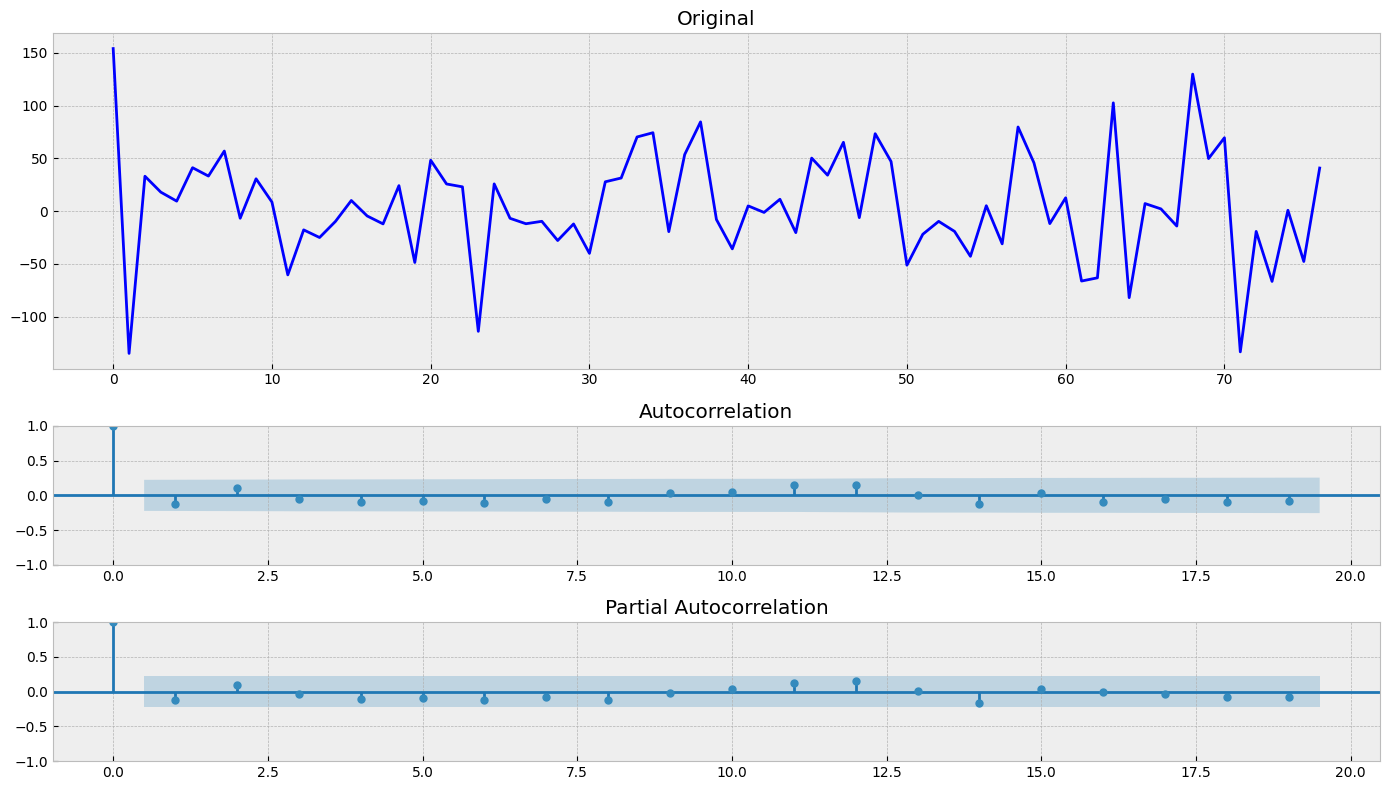

In [18]:
tsplot(model_fit.resid)

График остатков напоминает график стационарного ряда, но на нем присутсвуют заметные пики.

Обучение модели GARCH с полученными выше оптимальными значениями параметров:

In [85]:
garch_model = arch_model(series, mean='HAR', vol='GARCH', p=12, q=2, lags=2)
res_fit = garch_model.fit()
print(res_fit.summary())

Iteration:      1,   Func. Count:     20,   Neg. LLF: 64859.14187164051
Iteration:      2,   Func. Count:     43,   Neg. LLF: 437.8979781791567
Iteration:      3,   Func. Count:     63,   Neg. LLF: 441.5560911241214
Iteration:      4,   Func. Count:     83,   Neg. LLF: 445.8500061652801
Iteration:      5,   Func. Count:    103,   Neg. LLF: 430.66730886962665
Iteration:      6,   Func. Count:    122,   Neg. LLF: 446.2303543587067
Iteration:      7,   Func. Count:    144,   Neg. LLF: 540.5331378498233
Iteration:      8,   Func. Count:    165,   Neg. LLF: 441.3864162916466
Iteration:      9,   Func. Count:    185,   Neg. LLF: 428.43368545740594
Iteration:     10,   Func. Count:    204,   Neg. LLF: 441.83212063981466
Iteration:     11,   Func. Count:    224,   Neg. LLF: 427.9257063856683
Iteration:     12,   Func. Count:    243,   Neg. LLF: 427.9591042325607
Iteration:     13,   Func. Count:    263,   Neg. LLF: 427.6685916100303
Iteration:     14,   Func. Count:    282,   Neg. LLF: 427.477

График остатков:

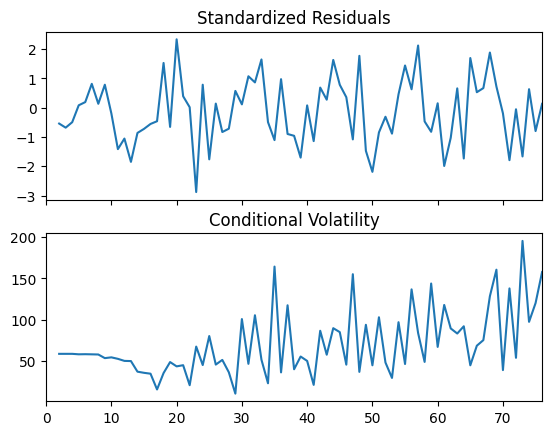

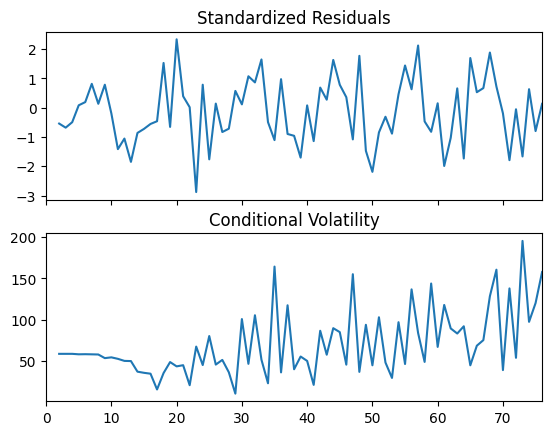

In [86]:
res_fit.plot()

График остатков сравним с полученным ранее на модели ARIMA.
Попробуем применить к ряду преобразование Бокса-Кокса и дифференцирование с лагом 7 и 12 (в сводке коэффициенты альфа [7] и [12] сильнее остальных отличаются от нуля), после чего еще раз применим моделирование GARCH.  

In [87]:
from scipy.stats import boxcox

In [88]:
series_x = boxcox(series, 0) # убираем нарастание дисперсии
series_x = series_x[7:] - series_x[:-7] # убираем тренд
series_x = series_x[12:] - series_x[:-12] # убираем сезонность

In [89]:
series_x = pd.Series(series_x)

In [90]:
series_x.isna().sum()

0

GARCH-модель ряда после преобразований:

In [91]:
garch_model_2 = arch_model(series_x, mean='HAR', vol='GARCH', p=12, q=2, lags=2)
res_fit_2 = garch_model_2.fit()
print(res_fit_2.summary())

Iteration:      1,   Func. Count:     20,   Neg. LLF: 67611835.45122087
Iteration:      2,   Func. Count:     41,   Neg. LLF: 1286.208306171993
Iteration:      3,   Func. Count:     63,   Neg. LLF: 13840.446812250499
Iteration:      4,   Func. Count:     84,   Neg. LLF: 99.83897085981096
Iteration:      5,   Func. Count:    105,   Neg. LLF: 9.269875115240627
Iteration:      6,   Func. Count:    126,   Neg. LLF: 17.07671974828
Iteration:      7,   Func. Count:    146,   Neg. LLF: 8.260284979989265
Iteration:      8,   Func. Count:    165,   Neg. LLF: 17.481437189857587
Iteration:      9,   Func. Count:    185,   Neg. LLF: 11.861728014184685
Iteration:     10,   Func. Count:    205,   Neg. LLF: 9.89328746982465
Iteration:     11,   Func. Count:    225,   Neg. LLF: 7.8379459501103375
Iteration:     12,   Func. Count:    245,   Neg. LLF: 6.767466902515324
Iteration:     13,   Func. Count:    264,   Neg. LLF: 9.85904011147948
Iteration:     14,   Func. Count:    285,   Neg. LLF: 7.847853638

График остатков:

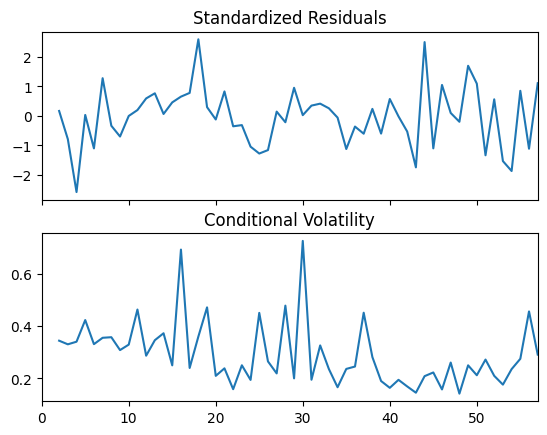

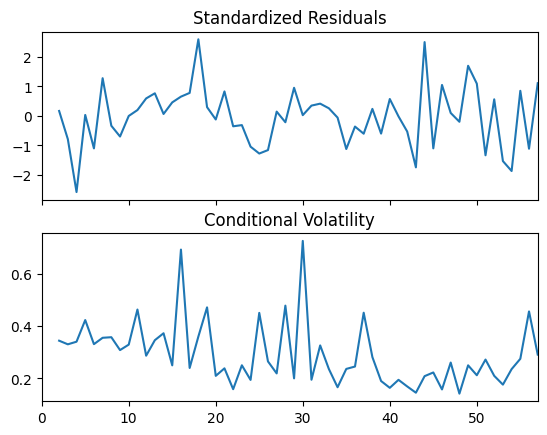

In [92]:
res_fit_2.plot()

Теперь гарфик остатков стал больше похож на белый шум. Судя по всему, для получения качественного результата для ряда без предварительных преобразований, необходима более тщательная настройка гиперпараметров модели GARCH, лучший подбор параметров (p, d, q) модели ARIMA или использование для этого другой модели, например SARIMA для подобного характера исходного временного ряда.